## Setup & Imports

In [1]:
!pwd

/content


In [2]:
# copy custom scripts from MyDrive to use in Colab
# ref: https://stackoverflow.com/a/74791011
!cp -r /content/drive/MyDrive/hashtag_rec/scripts/. /content/

In [2]:
# !pip install -r requirements.txt

In [5]:
# if running notebook in Google Colab, %load will not work - https://github.com/googlecolab/colabtools/issues/42
# copy paste the contents of constants.py file

# %load constants.py # uncomment this line to load in constants
# data constants
DATA_DIR = "./HARRISON" # REPLACE THIS with the directory path that you stored the HARRISON dataset in
DATA_LEN = 57383

# file path constants
INDICES_SPLIT_FILE_NAME = "data_indices_split.json"
IMG_PATHS_FILE_NAME = "data_list.txt"
GT_TAGS_FILE_NAME = "tag_list.txt"
EMBEDDINGS_FILE_NAME = "data_embeddings.txt"

# model constants
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
LLAVA_MODEL_NAME = "llava-hf/llava-1.5-7b-hf"
ST_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# df column constants
ID_COL = "img_id"
EMB_COL = "emb"
GT_COL = "gt_tags"
PRED_COL = "pred_tags"

# metric constants
ACCURACY = "acc"
PRECISION = "prec"
RECALL = "rec"
SEMANTIC_SIMILARITY = "sim"

In [6]:
import os
import json
import numpy as np
import pandas as pd

In [7]:
from data_utils import load_image_paths, load_image_tags
from eval_utils import evaluate_recommendations
from image_utils import get_image_from_fp, get_image_vectorizer_for_recommender
from index import create_index_from_df
from recommenders import ImageIndexTagRecommender, TagIndexTagRecommender, LlavaTagRecommender

## Load data split, image paths, image tags

In [8]:
with open(os.path.join(DATA_DIR, INDICES_SPLIT_FILE_NAME)) as f:
    indices_split = json.load(f)

In [9]:
img_fps = load_image_paths()

Loading image paths from file: ./HARRISON/data_list.txt
Finished loading 57383 image paths


In [10]:
tags_list = load_image_tags()

Loading image tags from file: ./HARRISON/tag_list.txt
Finished loading tags for 57383 images


In [50]:
test_imgs = [load_image_from_fp(os.path.join(DATA_DIR, img_fps[i])) for i in indices_split["test"]]
len(test_imgs)

500

## ImageIndex recommender

In [10]:
experiment_name = "clip_unweighted"

### Load embeddings

In [25]:
emb_fp = os.path.join(DATA_DIR, EMBEDDINGS_FILE_NAME)
emb_df = pd.read_json(emb_fp, lines=True)
emb_df.shape

(57333, 2)

In [12]:
train_df = emb_df[emb_df[ID_COL].isin(indices_split["train"])]
test_df = emb_df[emb_df[ID_COL].isin(indices_split["test"])]

In [13]:
test_idx_mapping = {i:img_id for i,img_id in enumerate(test_df[ID_COL])}

In [14]:
len(test_df), len(test_idx_mapping)

(500, 500)

### Create index

In [15]:
img_index, train_idx_mapping = create_index_from_df(train_df)

Creating index with vectors of shape: (56333, 512)


### Create recommender

In [57]:
recommender = ImageIndexTagRecommender(img_index, train_idx_mapping, tags_list)

### Get recommendations

In [17]:
rec_tags = recommender.get_tags_for_image_vector(np.array(test_df[EMB_COL].to_list()))
len(rec_tags)

500

In [30]:
rec_tags[:3]

[['flower', 'yellow', 'purple', 'spring', 'tree'],
 ['vscocam', 'vsco', 'nature', 'sky', 'tree'],
 ['baby', 'instagood', 'cute', 'love', 'family']]

In [20]:
# save recommendations to file
with open(os.path.join("recommendations", "test", f"recommendations_{experiment_name}.txt"), "w") as f:
    for i,(idx,row) in enumerate(test_df.iterrows()):
        img_id = row['img_id']
        gt_tags = tags_list[img_id]
        pred_tags = rec_tags[i]

        json.dump({"img_id": img_id, "gt_tags": gt_tags, "pred_tags": pred_tags}, f)
        f.write(os.linesep)

### Get recommendations from images

These should be the same results as getting from the precomputed image vectors

In [60]:
img_vectorizer = get_image_vectorizer_for_recommender()

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [67]:
recommender.get_tags_for_image(test_imgs[:3], img_vectorizer)

[['flower', 'yellow', 'purple', 'spring', 'tree'],
 ['vscocam', 'vsco', 'nature', 'sky', 'tree'],
 ['baby', 'instagood', 'cute', 'love', 'family']]

## TagIndex recommender

In [33]:
experiment_name = "clip_tag_index_unweighted"

### Load embeddings

In [23]:
tag_emb_fp = os.path.join(DATA_DIR, "clip_tag_embs.txt")
tag_emb_df = pd.read_json(emb_fp, lines=True)
tag_emb_df.shape

(997, 3)

### Create index

In [24]:
tag_index, tag_idx_mapping = create_index_from_df(tag_emb_df, id_col="tag_id")

Creating index with vectors of shape: (997, 512)


### Create recommender

In [29]:
idx_tag_mapping = tag_emb_df['tag'].to_dict()
len(idx_tag_mapping)

997

In [32]:
recommender = TagIndexTagRecommender(tag_index, tag_idx_mapping, list(idx_tag_mapping.values()))

### Get recommendations

In [34]:
rec_tags = recommender.get_tags_for_image_vector(np.array(test_df[EMB_COL].to_list()))
len(rec_tags)

500

In [35]:
rec_tags[:3]

[['purple', 'flowerstagram', 'plant', 'garden', 'grass'],
 ['bluesky', 'beautifulday', 'beach', 'beachlife', 'sunnyday'],
 ['holiday', 'vacation', 'sunnyday', 'webstagram', 'instaphoto']]

In [36]:
# save recommendations to file
with open(os.path.join("recommendations", "test", f"recommendations_{experiment_name}.txt"), "w") as f:
    for i,(idx,row) in enumerate(test_df.iterrows()):
        img_id = row['img_id']
        gt_tags = tags_list[img_id]
        pred_tags = rec_tags[i]

        json.dump({"img_id": img_id, "gt_tags": gt_tags, "pred_tags": pred_tags}, f)
        f.write(os.linesep)

## LLaVa Recommender

NOTE: This recommender makes use of the LLaVa model, which is multimodal LLM and requires heavy compute resource such as a GPU to run. It also takes more time to produce recommended tags than the other recommenders.

### Create recommender

In [41]:
recommender = LlavaTagRecommender()

Loading llava model...


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Finished loading llava model


### Get recommendations

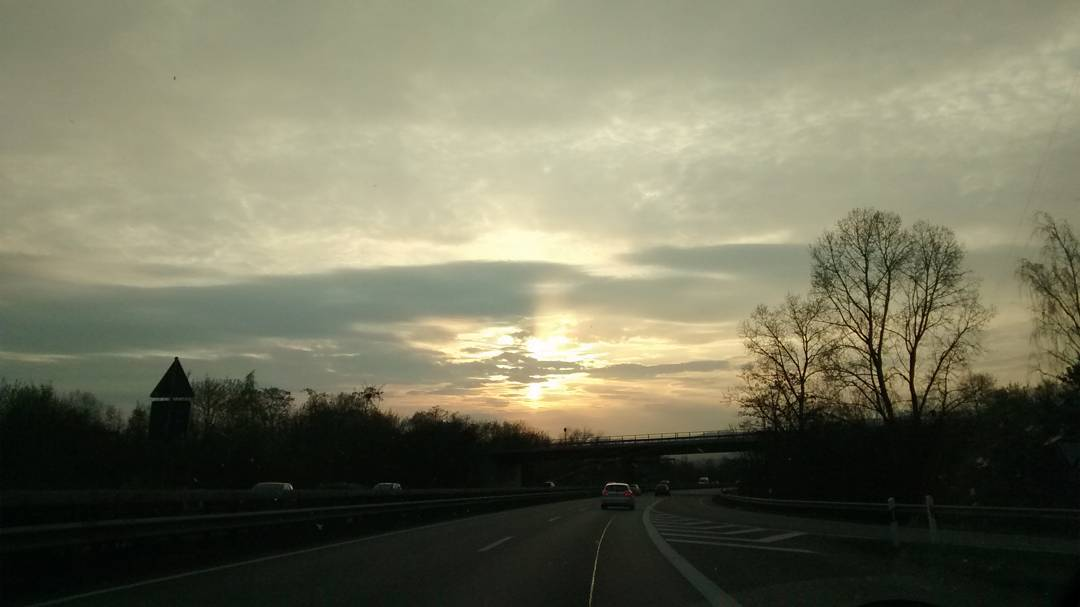

In [55]:
test_imgs[3]

In [56]:
recommender.get_tags_for_image(test_imgs[3])

['Sunset', 'Highway', 'Traffic', 'Clouds']

## Evaluate recommendations

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
st_model = SentenceTransformer(ST_MODEL_NAME)

In [38]:
experiment_name = "clip_unweighted"

In [40]:
pred_df = pd.read_json(os.path.join("recommendations", "test", f"recommendations_{experiment_name}.txt"), lines=True)
pred_df.shape

(500, 3)

In [24]:
eval_results = evaluate_recommendations(pred_df, st_model=st_model)

In [25]:
with open(os.path.join("eval_results", "test", f"eval_results_{experiment_name}.json"), "w") as f:
    json.dump(eval_results, f, indent=2)

## Visualizations

In [10]:
def graph_metric(metric_name, df):
    df_to_graph = df[df["metric"] == metric_name].copy()
    return alt.Chart(df_to_graph).mark_line().encode(
        x="k:O",
        y="value",
        color="method"
    ).properties(
        title=metric_name,
        width=300,
        height=200
    )

### Load and reformat data

In [11]:
eval_results_dir = os.path.join("eval_results", "test")

In [ ]:
eval_results_data = []
for file_name in os.listdir(os.path.join(eval_results_dir)):
    print(file_name)
    fp = os.path.join(eval_results_dir, file_name)
    
    with open(fp) as f:
        eval_results_json = json.load(f)
    for metric_name, results_dict in eval_results_json.items():
        for k,result in results_dict.items():
            eval_results_data.append({"method": file_name[13:-15], "metric": metric_name, "k": k, "value": result})
len(eval_results_data)

In [84]:
eval_results_df = pd.DataFrame(eval_results_data)
eval_results_df.shape

(80, 4)

In [85]:
metric_names = {"acc": "Accuracy", "rec": "Recall", "prec": "Precision", "sim": "Semantic Similarity"}

In [86]:
method_names = {
    "clip_unweighted": "CLIP image embeddings",
    "tag_index_unweighted": "CLIP image-text embeddings",
    "vit_unweighted": "ViT image embeddings",
    "llava_unweighted": "LLaVa",
    "clip_clip_weighted": "CLIP image embeddings",
    "tag_index_clip_weighted": "CLIP image-text embeddings",
    "vit_clip_weighted": "ViT image embeddings",
    "llava_clip_weighted": "LLaVa"
}

In [87]:
eval_results_df['metric'] = eval_results_df['metric'].replace(metric_names)
eval_results_df['method'] = eval_results_df['method'].replace(method_names)

### Graphs

In [9]:
import altair as alt

In [56]:
acc_graph = graph_metric(metric_names["acc"], eval_results_df)
prec_graph = graph_metric(metric_names["prec"], eval_results_df)
rec_graph = graph_metric(metric_names["rec"], eval_results_df)
sim_graph = graph_metric(metric_names["sim"], eval_results_df)

In [57]:
((acc_graph | prec_graph) | rec_graph) | sim_graph

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: Futu

alt.HConcatChart(...)

In [58]:
acc_graph | prec_graph

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.HConcatChart(...)

In [59]:
rec_graph | sim_graph

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.HConcatChart(...)

### Tables

In [74]:
from IPython.core.display import display, HTML

In [88]:
display(HTML(eval_results_df[eval_results_df['metric'] == metric_names['sim']].pivot(columns="k", index='method', values='value').to_html(index=True)))

k,1,2,3,4,5
method,,,,,
CLIP image embeddings,0.563370,0.549062,0.542823,0.527517,0.513780
CLIP image-text embeddings,0.486584,0.476270,0.467467,0.458840,0.449831
LLaVa,0.444861,0.436609,0.434182,0.430315,0.423269
ViT image embeddings,0.541675,0.528770,0.515248,0.499057,0.492067
